# Scratch Notebook

In [1]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", True)
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import optax
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning
import models

from jax.experimental import optimizers

key, subkey = random.split(random.PRNGKey(0))

from jax.scipy.stats import norm

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [1974]:
%autoreload

In [1995]:
target = distributions.Gaussian(0, 1)
proposal = distributions.Gaussian(-3, 1)

key, subkey = random.split(key)
gradient = models.EnergyGradient(target, subkey)
key, subkey = random.split(key)
particles = models.Particles(subkey, gradient.gradient, proposal, n_particles=50, num_groups=1, learning_rate=1e-1, optimizer="adam", noise_level=1.)

In [1996]:
scales = []
for _ in range(100):
    particles.step(None)
    scales.append(onp.squeeze(onp.abs(particles.noise_scales)).tolist())

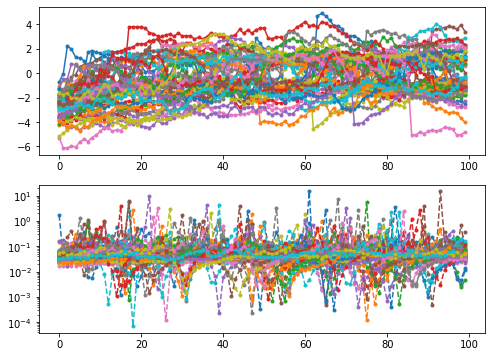

In [1997]:
fig, axs = plt.subplots(2, figsize=[8, 6])
particles.plot_trajectories(marker=".", ax=axs[0])
axs[1].plot(scales, "--.")
plt.yscale("log")

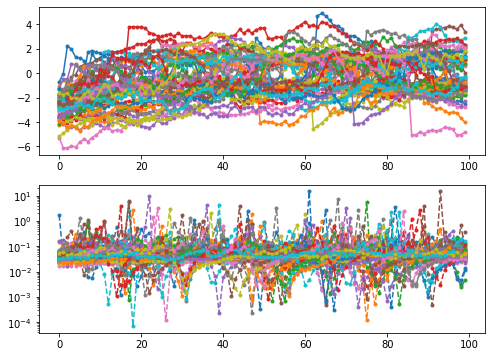

In [1998]:
fig, axs = plt.subplots(2, figsize=[8, 6])
particles.plot_trajectories(marker=".", ax=axs[0])
axs[1].plot(scales, "--.")
plt.yscale("log")

# dists

In [2]:
from distributions import Gaussian as G

In [3]:
%autoreload

In [4]:
target = G(0,1)

In [5]:
learner = models.SDLearner(target)
particles = models.Particles(key, learner.gradient, target)

In [12]:
learner.train(particles.next_batch, key=subkey, n_steps=5)
particles.step(learner.get_params())

In [13]:
learner.rundata["train_steps"]

[4, 4]

In [14]:
learner.step_counter

10

In [15]:
learner.rundata["step_counter"]

[DeviceArray(0, dtype=int32),
 DeviceArray(1, dtype=int32),
 DeviceArray(2, dtype=int32),
 DeviceArray(3, dtype=int32),
 DeviceArray(4, dtype=int32),
 DeviceArray(5, dtype=int32),
 DeviceArray(6, dtype=int32),
 DeviceArray(7, dtype=int32),
 DeviceArray(8, dtype=int32),
 DeviceArray(9, dtype=int32)]

# check if dists have correct statistics

In [3]:
%autoreload

In [4]:
def check_dist(dist, key):
    s = dist.sample(10**4, key=key)
    errs = {
        "se_mean": np.sum((np.mean(s, axis=0) - dist.mean)**2),
        "se_cov": np.sum((np.cov(s, rowvar=False) - dist.cov)**2),
    }
    for k, err in errs.items():
        if err > 1e-2:
            print(f"{k} to big! {k} = {err} > 0.01")
    return

In [5]:
dist = distributions.Gaussian(0, 1)
check_dist(dist, key)

In [6]:
dist, _ = distributions.funnel.get()
check_dist(dist, key) # fine, just hard to approximate

se_cov to big! se_cov = 0.031472012400627136 > 0.01


In [7]:
dist, _ = distributions.banana_target.get()
check_dist(dist, key) # fine

se_cov to big! se_cov = 0.27654290199279785 > 0.01


In [8]:
dist, _ = distributions.ring_target.get()
check_dist(dist, key) # fine

se_mean to big! se_mean = 0.02532472275197506 > 0.01
se_cov to big! se_cov = 4.020059585571289 > 0.01


In [19]:
dist, _ = distributions.squiggle_target.get()
check_dist(dist, key)